In [1]:
#  monter le google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ProjetDeep/

/content/drive/MyDrive/ProjetDeep


# Liste des imports

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, Concatenate,GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from keras.utils import to_categorical
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.applications import VGG16
from keras.layers import Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
import math
import pickle
import json
import pandas

#CHARGEMENT DES DONNEES ET EXTRACTION DE X_Train , Y_train , X_test , Y_test

In [3]:

IMG_SIZE = 224
DATADIR = "/content/drive/MyDrive/ProjetDeep/BarkNet/BarkNet_train"

CATEGORIES = ["BOJ", "BOP", "CHR", "EPB", "EPN", "EPO","EPR", "ERR", "ERS", "FRA","HEG","MEL","ORA","OSV","PET","PIB","PIR","PRU","SAB","THO"]
training_data = []
# fonction pour charger les données train à partir du drive  
def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num]) 
            except Exception as e: 
                pass

    
DATATESTDIR = "/content/drive/MyDrive/ProjetDeep/BarkNet/BarkNet_test"
test_data = []
# fonction pour charger les données test à partir du drive 
def create_testing_data():
    for category in CATEGORIES:  

        path = os.path.join(DATATESTDIR,category) 
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                test_data.append([new_array, class_num])  
            except Exception as e:  
                pass

In [5]:
create_training_data()

100%|██████████| 58/58 [00:14<00:00,  4.14it/s]


In [6]:
print(len(training_data))

1914


In [7]:
create_testing_data()

100%|██████████| 17/17 [00:03<00:00,  4.71it/s]


In [27]:
print(len(test_data))

In [8]:

# mélanger l'ensemble d'entrainement
random.shuffle(training_data)

#Extraction de X_train , y_train

In [10]:
X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(X_train.shape)
print(len(y_train))

(1914, 224, 224, 3)
1914


#Extraction de X_test , y_test

In [11]:
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(X_test.shape)
print(len(y_test))

(448, 224, 224, 3)
448


#construire le modéle

In [12]:
def build_model():
   inputs = Input((224,224,3))
   conv1 = Conv2D(96,(7,7),padding='same',activation='relu',strides=2)(inputs)
   maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv1)  
    # 1er Fire Module
   fire1_squeeze = Conv2D(16, kernel_size=(1,1),padding='same',activation='relu')(maxpool1)
   fire1_expand1 = Conv2D(64, kernel_size=(1,1),padding='same',activation='relu')(fire1_squeeze)
   fire1_expand2 = Conv2D(64, kernel_size=(3,3),padding='same',activation='relu')(fire1_squeeze)
   concatenate_1 = Concatenate()([fire1_expand1, fire1_expand2])
   # 2er Fire Module
   fire2_squeeze = Conv2D(16, kernel_size=(1,1),padding='same',activation='relu')(concatenate_1)
   fire2_expand1 = Conv2D(64, kernel_size=(1,1),padding='same',activation='relu')(fire2_squeeze)
   fire2_expand2 = Conv2D(64, kernel_size=(3,3),padding='same',activation='relu')(fire2_squeeze)
   concatenate_2 = Concatenate()([fire2_expand1, fire2_expand2])
   # 3er Fire Module
   fire3_squeeze = Conv2D(32, kernel_size=(1,1),padding='same',activation='relu')(concatenate_2)
   fire3_expand1 = Conv2D(128, kernel_size=(1,1),padding='same',activation='relu')(fire3_squeeze)
   fire3_expand2 = Conv2D(128, kernel_size=(3,3),padding='same',activation='relu')(fire3_squeeze)
   concatenate_3 = Concatenate()([fire3_expand1, fire3_expand2])

   maxpool2 = MaxPooling2D(pool_size=(3, 3),padding='same', strides=2)(concatenate_3)
   # 4er Fire Module
   fire4_squeeze = Conv2D(32, kernel_size=(1,1),padding='same',activation='relu')(maxpool2)
   fire4_expand1 = Conv2D(128, kernel_size=(1,1),padding='same',activation='relu')(fire4_squeeze)
   fire4_expand2 = Conv2D(128, kernel_size=(3,3),padding='same',activation='relu')(fire4_squeeze)
   concatenate_4 = Concatenate()([fire4_expand1, fire4_expand2])
   # FC
   drop = Dropout(0.5)(concatenate_4)
   conv2 = Conv2D(20, kernel_size=(1,1),padding='valid',activation='relu')(drop)
   gap = GlobalAveragePooling2D()(conv2)
   softmax = Activation("softmax")(gap)
   model = Model(inputs=inputs, outputs=softmax)
   opt = keras.optimizers.Adam(learning_rate=0.001)  
   model.compile(loss= 'categorical_crossentropy' , optimizer= opt , metrics=['accuracy'])
   return model

#Grille de recherche 

In [13]:
epochs=20
batch_size=8
model = KerasClassifier(build_fn=build_model,epochs=epochs,batch_size=batch_size)
# definir les params à évaluer par la grille
param_grid = {"epochs" : [20,40,60,80,100],
"batch_size" : [8, 16, 32, 64, 128]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)


grid_result = grid.fit(X_train,y_train,verbose=2)
# afficher les résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20


KeyboardInterrupt: ignored

#Data augmentation

In [18]:
#charger la Datase
BASE_PATH = "BarkNet"
TRAIN = "BarkNet_train"
TEST = "BarkNet_test"

# chemins vers les repertoires train, val et test
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
testPath = os.path.sep.join([BASE_PATH, TEST])

# nbr total des image dans chacun des repo train test
totalTrain = len(list(paths.list_images(trainPath)))
print(totalTrain)
# totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTest)

1912
448


#Data augmentation

In [19]:

batch_size = 128
epochs = 100


# instancier un objet ImageDataGenerator pour l'augmentation des donnees train

trainAug = ImageDataGenerator(
    horizontal_flip=True,)

# instancier un objet ImageDataGenerator pour l'augmentation des donnees test
testAug = ImageDataGenerator()

# definir la moyenne des images ImageNet par plan RGB pour normaliser les images de la BarkNet
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
testAug.mean = mean

# initialiser le generateur de train

trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)

#x, y = next(trainGen)

# initialiser le generateur de test
testGen  = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=False,
   
    batch_size=batch_size)

Found 1912 images belonging to 20 classes.
Found 448 images belonging to 20 classes.


# entrainement du model

In [20]:

model = build_model()
H = model.fit_generator(trainGen,
     steps_per_epoch=totalTrain // batch_size,
     validation_data=testGen,
     validation_steps=totalTest // batch_size,
     epochs=epochs) 


#H  = model.fit(trainGen, validation_data=testGen , verbose=1,batch_size=batch_size,epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
14/14 [==============================] - 7s 497ms/step - loss: 3.0011 - accuracy: 0.0869 - val_loss: 2.8876 - val_accuracy: 0.1510
Epoch 2/100
14/14 [==============================] - 6s 437ms/step - loss: 2.9146 - accuracy: 0.0981 - val_loss: 2.8913 - val_accuracy: 0.1510
Epoch 3/100
14/14 [==============================] - 6s 445ms/step - loss: 2.9083 - accuracy: 0.1132 - val_loss: 2.8669 - val_accuracy: 0.1510
Epoch 4/100
14/14 [==============================] - 6s 441ms/step - loss: 2.9201 - accuracy: 0.1099 - val_loss: 2.8937 - val_accuracy: 0.1510
Epoch 5/100
14/14 [==============================] - 6s 446ms/step - loss: 2.8969 - accuracy: 0.0908 - val_loss: 2.8720 - val_accuracy: 0.1510
Epoch 6/100
14/14 [==============================] - 6s 455ms/step - loss: 2.8972 - accuracy: 0.1066 - val_loss: 2.8705 - val_accuracy: 0.1510
Epoch 7/100
14/14 [==============================] - 6s 448ms/step

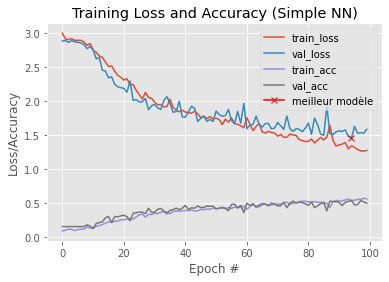

In [21]:
# afficher le graphe de loss et accuracy
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,100)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("Loss_Acc_mnist")


#Dégradation du taux d'apprentissage

In [22]:
model = build_model()
def lr_decay(epoch, current_learning_rate):
    if epoch ==65:
       return current_learning_rate * 0.2
    else:
       return current_learning_rate

# learning schedule callback
lrate = LearningRateScheduler(lr_decay,verbose=1)
callbacks_list = [lrate]


H=model.fit(trainGen,validation_data= testGen ,callbacks=callbacks_list, verbose=1,batch_size=batch_size,epochs=epochs)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/100
15/15 [==============================] - 7s 457ms/step - loss: 2.9465 - accuracy: 0.1025 - val_loss: 2.9343 - val_accuracy: 0.1295

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/100
15/15 [==============================] - 6s 414ms/step - loss: 2.9054 - accuracy: 0.1109 - val_loss: 2.9252 - val_accuracy: 0.1295

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/100
15/15 [==============================] - 6s 413ms/step - loss: 2.8949 - accuracy: 0.1036 - val_loss: 2.9287 - val_accuracy: 0.1339

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/100
15/15 [==============================] - 6s 408ms/step - loss: 2.8817 - accuracy: 0.1020 - val_loss: 2.9318 - val_accuracy: 0.0558

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epo

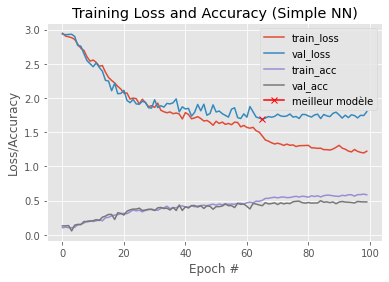

In [23]:
# afficher le graphe de loss et accuracy
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,100)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("Loss_Acc_mnist")

#Sauvegarde de l'historique d'entrainement

In [41]:
with open('file.json', 'w') as f:
    json.dump(str(H.history), f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Sauvegarde du modèle

In [24]:
model.save("partie1.h5")
print("modèle sauvegardé")

modèle sauvegardé


#Chargement du modèle

In [25]:
from keras.models import load_model

model = load_model('partie1.h5')
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 112, 112, 96) 14208       input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 55, 55, 96)   0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 55, 55, 16)   1552        max_pooling2d_6[0][0]            
_______________________________________________________________________________________

#Visualisation des mesures de performance 

In [59]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# evaluer le modele sur l'ensemble test
predictions = model.predict(testGen, batch_size=batch_size)

# imprimer le rappel/ precision ainsi que la mesure F
CATEGORIES = ["BOJ", "BOP", "CHR", "EPB", "EPN", "EPO","EPR", "ERR", "ERS", "FRA","HEG","MEL","ORA","OSV","PET","PIB","PIR","PRU","SAB","THO"]
report =classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1),target_names=CATEGORIES,output_dict=True)




#Sauvegarde des mesures de performances

In [61]:
df = pandas.DataFrame(report).transpose()
print(df)
df.to_csv('performance.csv',index=True)


              precision    recall  f1-score     support
BOJ            0.736842  0.518519  0.608696   27.000000
BOP            0.680851  0.969697  0.800000   33.000000
CHR            0.555556  0.344828  0.425532   58.000000
EPB            0.444444  0.307692  0.363636   13.000000
EPN            0.250000  0.466667  0.325581   15.000000
EPO            0.285714  0.153846  0.200000   26.000000
EPR            0.000000  0.000000  0.000000   19.000000
ERR            0.250000  0.428571  0.315789   28.000000
ERS            0.210526  0.444444  0.285714   27.000000
FRA            0.558824  1.000000  0.716981   19.000000
HEG            0.857143  0.705882  0.774194   17.000000
MEL            0.620000  0.837838  0.712644   37.000000
ORA            0.600000  0.473684  0.529412   19.000000
OSV            0.000000  0.000000  0.000000   10.000000
PET            0.857143  0.600000  0.705882   20.000000
PIB            0.384615  0.227273  0.285714   22.000000
PIR            0.250000  0.250000  0.250000    8

#Visualisation et sauvegarde du graphe 

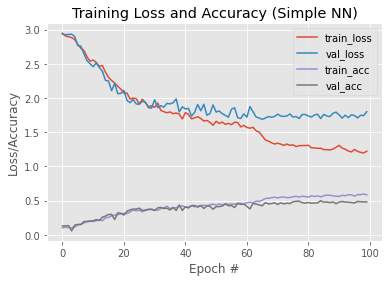

In [44]:
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#sauvegarde du graphe
plt.savefig("BarkNet_partie1.PNG")